# Pre-processing
Quality control

Average technical replicates

Eliminate standard samples

Filter samples & features

Authors: Andrei Todor, Shuzhao Li

In [1]:
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind, f_oneway
from statsmodels.sandbox.stats.multicomp import multipletests
from pylab import savefig
from math import log
import matplotlib.pyplot as plt

## Set up file format options

Each row has a number of header attributes, listed before the intensity values for each technical replicate.

In [2]:
# number of initial columns
frontcols = 4

Sometimes the column names in the feature table are within quotation marks

In [3]:
# file names are within quotation marks in arg 1 (0/1)
quotes = 0

Sometimes the sample identifiers in the sequence file end in _1, _2, ..., etc., where _1, _2, ... indicate the technical replicate number

In [4]:
# sample ids are subscripted in arg 2 (0/1)
subscripted = 1

Sometimes the column names in the feature table include the extension of the file name to which they correspond

In [5]:
# file name have extension in arg 1
extension = 1

# Read feature table

In [6]:
infile = "../data/features_pos.txt"
mydata = pd.read_table(infile)
header = [x for x in mydata]

# Set up file name to sample name association
Each column in the feature table is identified by a file name, and each file contains data from one technical replicate. For a meaningful biological analysis we want to compare biological samples. Therefore the association between file names and biological samples needs to be established. This association is found in the sequence file and we need to retrieve it.

In [7]:
# which samples are standards? 
def is_sample(field):
    return "nist" not in field and "q3" not in field and "wash" not in field

# sequence file
samplesfile = "../data/cdf_keys.csv"

#file name to sample name dictionary
sample_ids = {}
sample_dict = {}
sampledata = open(samplesfile).readlines()
for line in sampledata[1:]:
    dt = line.rstrip().split("\t")
    if (subscripted == 1):
        sample_dict[dt[0]] = dt[1][:-2]
    else:
        sample_dict[dt[0]] = dt[1]
    if is_sample(dt[1]):
        sample_ids[dt[1][:-2]] = []

In [8]:
# sample names to file names dictionary
for sid in sample_ids:
    for s in range(len(header) - frontcols):
        f = header[s + frontcols]
        if quotes == 1:
            k = f[1 : len(f) - 1].split('.')
        else:
            k = f.split('.')
        if extension == 1:
            fn = '.'.join(k[:len(k) - 1])
        else:
            fn = k[0]
        if sample_dict.has_key(fn):
            field_name = sample_dict[fn]
            if (sid == field_name):
                sample_ids[sid].append(s)
print(sample_ids)

{'yf_6hr_02': [21, 22, 23], 'yf_6hr_03': [24, 25, 26], 'yf_6hr_01': [18, 19, 20], 'p_0hr_02': [3, 4, 5], 'p_0hr_03': [15, 16, 17], 'p_0hr_01': [0, 1, 2], 'mock_6hr_01': [6, 7, 8], 'mock_6hr_03': [12, 13, 14], 'mock_6hr_02': [9, 10, 11]}


# Quality control

Plot average intensity in samples

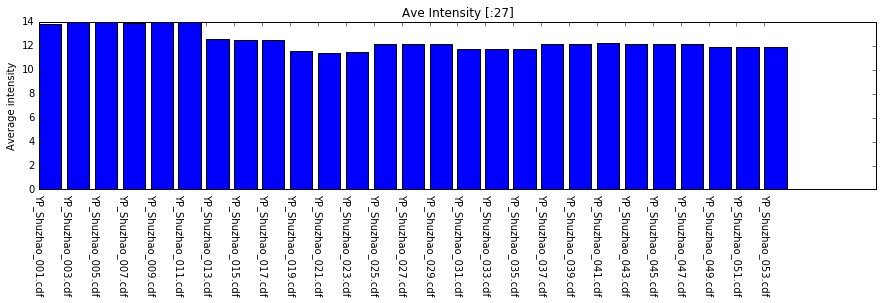

In [9]:
new_header = [x for x in mydata][frontcols:]
log_data = np.log2(mydata + 1)
mean_TIC = log_data.mean(0)
# plot bars for first N columns
N = min(50, len(new_header))
ind = np.arange(N)
plt.figure(figsize=(15,3))
plt.bar(ind, mean_TIC[frontcols:frontcols+N])
plt.ylabel("Average intensity")
plt.title("Ave Intensity [:%d]" %N)
plt.xticks(ind, mydata.columns[frontcols : N + frontcols], rotation=-90)
plt.show()

Distribution of signal intensities in histograms

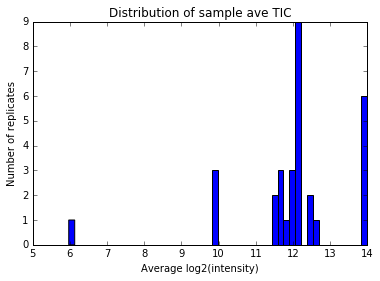

In [10]:
# only if the sample number is large
import matplotlib.mlab as mlab
num_bins = 50
plt.figure(figsize=(6,4))
plt.hist(mean_TIC, num_bins, normed=0)
plt.title("Distribution of sample ave TIC")
plt.xlabel("Average log2(intensity)")
plt.ylabel("Number of replicates")
plt.show()

Distribution of signal intensities in histograms, without NIST or Qstd samples


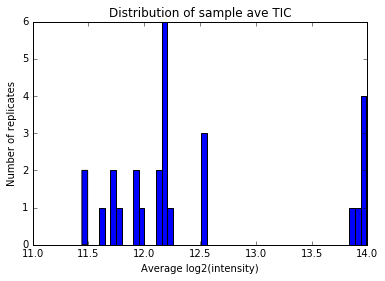

~~~ Samples with ave log2 intensity < 10:
('YP_Shuzhao_001.cdf', 9.8806287519851566)
('YP_Shuzhao_003.cdf', 5.9722266569816034)
('YP_Shuzhao_005.cdf', 9.8806285350790723)
('YP_Shuzhao_007.cdf', 9.880628976634382)


In [11]:
# to exclude reference samples:
sample_header = [x for x in header[frontcols:] if is_sample(x)]
sample_data = log_data[ sample_header ]

plt.figure(figsize=(6,4))
plt.hist(sample_data.mean(0), num_bins, normed=0)
plt.title("Distribution of sample ave TIC")
plt.xlabel("Average log2(intensity)")
plt.ylabel("Number of replicates")
plt.show()

# this new plot shows that the reference samples were clustered around X=11.3
# and there are a few samples with very low intensities, which should be taken out

# alternative way to show:
low_intensity_replicates = []
print("~~~ Samples with ave log2 intensity < 10:")
for i in range(len(mean_TIC)):
    if mean_TIC[i] < 10:
        low_intensity_replicates.append(header[i + frontcols])
        print(header[i + frontcols], mean_TIC[i])

Determine which replicates to remove: pairwise correlations between technical replicates of the same sample must be smaller than cutoff.

In [12]:
# sample correlation threshold
corr_thr = 0.3

def call_bad_replicate(CorrDataFrame, corr_CUTOFF):
    # assuming three replicates here, 
    # return list of bad replicates
    names = [x for x in CorrDataFrame]
    good = []
    if CorrDataFrame.values[0, 1] > corr_CUTOFF:
        good += [names[0], names[1]]
        
    if CorrDataFrame.values[0, 2] > corr_CUTOFF:
        good += [names[0], names[2]]
        
    if CorrDataFrame.values[1, 2] > corr_CUTOFF:
        good += [names[1], names[2]]

    return [x for x in names if x not in good]

all_Pearson_coefficients, bad_replicates = [], []
for k,v in sample_ids.items():
    if len(v) == 3:  # only do if three replicates
        Pr = log_data[[header[x + frontcols] for x in v]].corr()
        all_Pearson_coefficients.append((v, Pr))
        bad = call_bad_replicate(Pr, corr_thr)
        if bad:
            bad_replicates += bad
            print("- Bad corr - %s" %str(bad))
            # uncomment below to see the whole corr matrix
            #print(Pr)
    
# For this example dataset, many Qstd samples have the same name. Skipping them for now.
# Alternative method can use stats.pearsonr and itertools.combinations

# compare low_intensity_replicates with bad_replicates
print("Overlap btw low_intensity_replicates and bad_replicates:" )
print(set(low_intensity_replicates).intersection(set(bad_replicates)))

Overlap btw low_intensity_replicates and bad_replicates:
set([])


# Filter replicates

In [13]:
# update sample_ids dictionary
black_list = set(low_intensity_replicates + bad_replicates)
new_sample_ids = {}
for k,v in sample_ids.items():
    new = [x for x in v if header[x + frontcols] not in black_list]
    if new:
        if is_sample(k):
            new_sample_ids[k] = new

# Set up sample groups
We assume that the analysis involves comparison between two or more groups or classes of samples. The identifiers of samples corresponding to each group are listed in a separate text file, one file per group.

In [14]:
# sample groups
sample_files = ["../data/samples_p.csv", "../data/samples_mock.csv", "../data/samples_yf.csv"]

g = []
for gf in sample_files:
    f = open(gf, 'r')
    ids = [id.rstrip() for id in f.readlines() if len(id.strip()) > 0]
    if len(ids) > 0:
        g.append(ids)
    f.close()

# Filter features & average technical replicates
Take average of non-zero values of technical replicates of each sample

For each feature, percentage of non-zero values in at least one group must be larger than threshold, otherwise feature is eliminated.

Compute presence histogram

Write processed feature table to file.

In [15]:
# zeros percentage threshold
pres = 0.5

filter_header = [] # new header
for i in range(frontcols): # initial columns
    filter_header.append(header[i]) 
for gr in g:
    for sid in gr:
        if new_sample_ids.has_key(sid):
            filter_header.append(sid)
filter_data = []
zero_hist = [0.0] * (len(new_sample_ids.keys()) + 1)
for k in range(log_data.shape[0]):
    line = log_data.iloc[k]
    nl = []
    nz = [0] * len(g)
    for i in range(frontcols): # initial columns
        nl.append(mydata.iloc[k][i])
    for i in range(len(g)):
        gr = g[i]
        for sid in gr:
            if new_sample_ids.has_key(sid):
                st = [line[x + frontcols] for x in new_sample_ids[sid] if line[x + frontcols] > 1]
                m = 0 if len(st) == 0 else np.mean(st)
                #print(st)
                if m > 0.0001:
                    nz[i] = nz[i] + 1
                nl.append(m)
    if any([float(nz[i])/float(len(g[i])) > pres for i in range(len(g))]):    
        filter_data.append(nl)
    zero_hist[sum(nz)] += 1

# write output
out_dir = "../results"
with open(out_dir + "/features_avg_pos.txt", 'w') as file:
    file.write('\t'.join(filter_header))
    file.write("\n")
    for line in filter_data:
        file.write('\t'.join([str(x) for x in line]))
        file.write("\n")

# Plot zeros histogram

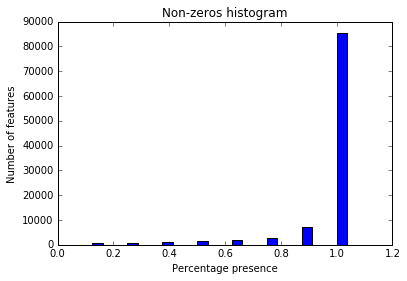

In [23]:
n = len(zero_hist)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([float(x)/float(n-1) for x in range(n)], zero_hist, 0.3/float(len(new_sample_ids.keys())))
plt.title("Non-zeros histogram")
plt.xlabel("Percentage presence")
plt.ylabel("Number of features")
plt.show()